In [1]:
import sqlite3
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import re
import math
%matplotlib inline

In [56]:
plt.rcParams['font.family'] = 'IPAGothic'

In [3]:
conn = sqlite3.connect('/home/kyohei/npb_blog_validation/satozaki/players_info.db')
c = conn.cursor()

In [4]:
# 野手成績の取得
df_fielder = pd.read_sql('select * from fielder_score', conn)
# 投手情報の取得
df_pitcher = pd.read_sql('select * from pitcher_score', conn)
# 選手の基本情報の取得
df_bios = pd.read_sql('select * from bios', conn)

In [4]:
# 生年月日が空の選手を除外する。
df_bios.dropna(subset=['生年月日'], inplace=True, axis=0)

In [5]:
# 生年月日を年と月と日に分割
bios_year = df_bios['生年月日'].astype(str).str.extract('([0-9]*)年', expand=True)
bios_month = df_bios['生年月日'].astype(str).str.extract('([0-9]*)月', expand=True)
bios_day = df_bios['生年月日'].astype(str).str.extract('([0-9]*)日', expand=True)
# 生年月日を再統合
bios_birth = pd.concat([bios_year, bios_month, bios_day], axis=1)

bios_birth.columns = ['年', '月', '日']

# 年情報しか無い選手がいるので、そういった選手は4/1生まれとした。
values = {'月': 4, '日': 1}
bios_birth_fill = bios_birth.fillna(value=values)

# 整数型に変更
bios_birth_fill = bios_birth_fill.astype({'年': int, '月': int, '日': int})

# 早生まれなら1
bios_birth_fill['月_変換'] = bios_birth_fill['月'].apply(lambda x: 0 if x-4>=0 else 1)

# 統合用にデータを限定
bios_birth_fill_edit = bios_birth_fill[['年', '月_変換']]
# 統合する。
df_bios_year_month = pd.concat([df_bios, bios_birth_fill_edit], axis=1)

In [6]:
# 選手成績情報で二期せいだった頃の年度を一つにする。
df_pitcher.loc[:, '年度'] = df_pitcher['年度'].str.extract('^([0-9]*)').astype(int)
# biosの方のデータを統合用に編集
df_merge_edit = df_bios_year_month[['url', '年', '月_変換']]
# 成績データと合体
merge_pitcher = df_pitcher.merge(df_merge_edit, on='url', how='inner')
# 満年齢を計算
merge_pitcher['満年齢'] = merge_pitcher.apply(lambda x:x.loc['年度'] - x.loc['年'] + x.loc['月_変換'], axis=1)

/home/kyohei/anaconda2/envs/py36con/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [7]:
# 選手成績情報で二期せいだった頃の年度を一つにする。
df_fielder.loc[:, '年度'] = df_fielder['年度'].str.extract('^([0-9]*)').astype(int)
# biosの方のデータを統合用に編集
df_merge_edit = df_bios_year_month[['url', '年', '月_変換']]
# 成績データと合体
merge_fielder = df_fielder.merge(df_merge_edit, on='url', how='inner')
# 満年齢を計算
merge_fielder['満年齢'] = merge_fielder.apply(lambda x:x.loc['年度'] - x.loc['年'] + x.loc['月_変換'], axis=1)

/home/kyohei/anaconda2/envs/py36con/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [8]:
# 野手情報を年度、所属球団、満年齢に限定
df_fielder_mid = merge_fielder[merge_fielder['年度']>=1951][['年度', '所属球団', '満年齢']]
# 投手情報を年度、所属球団、満年齢に限定
df_pitcher_mid = merge_pitcher[merge_pitcher['年度']>=1951][['年度', '所属球団', '満年齢']]
# 控え、レギュラー全選手のデータ
df_allplayer_row = pd.concat([df_fielder_mid, df_pitcher_mid], axis=0, ignore_index=True)

/home/kyohei/anaconda2/envs/py36con/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


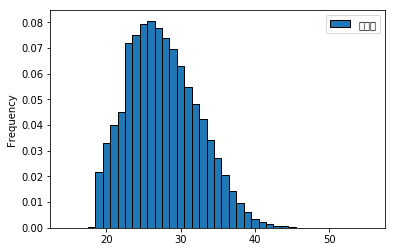

In [57]:
# 全選手の年齢分布
bins = np.linspace(14.5, 55.5, 42)
df_allplayer_row.plot(kind='hist', y='満年齢', ec='black',bins=bins, normed=True)

- 一軍登録のあった選手の分布
- 24歳でその件数がぐいっと上がっている。それぐらいの年になると使える選手が出てくるというところだろうか。ただ、全選手で見ているので、レギュラークラスということであれば、また違った形になるかもしれない

In [10]:
# 次は投球回の分布
# 投球回は1/3イニングとかある。端数は全て切り上げて考えている。
# math.ceil()で切り上げ
merge_pitcher.loc[:, '投球回_修正'] = merge_pitcher['投球回'].apply(lambda x: re.sub('\s','',x)).astype(float).apply(lambda x: math.ceil(x))

In [11]:
# 投手について主力選手に限定する。
# 投球回数と登板回数のor条件で見る。両方共上位20%の選手を主力選手とみなす。
# 登板回数
number_toban = merge_pitcher[merge_pitcher['年度']>=1951].groupby(['年度', '所属球団'])['登板'].apply(lambda x:np.percentile(x, 80)).reset_index()
# 投球回数
number_ining = merge_pitcher[merge_pitcher['年度']>=1951].groupby(['年度', '所属球団'])['投球回_修正'].apply(lambda x:np.percentile(x, 80)).reset_index()
# 年度と所属球団別の抽出条件をテーブル化
condition_pitcher = number_toban.merge(number_ining, on=['年度', '所属球団'])
# 元の投手のDFと、抽出条件のDFを統合
merge_pitcher_mid = merge_pitcher.merge(condition_pitcher, on=['年度', '所属球団'])
# 抽出条件を適用した、マスキング情報
mask = (merge_pitcher_mid.apply(lambda x: x.loc['登板_x']>=x.loc['登板_y'], axis=1)) | (merge_pitcher_mid.apply(lambda x: x.loc['投球回_修正_x']>=x.loc['投球回_修正_y'], axis=1))
# 投手の抽出情報
merge_pitcher_condition = merge_pitcher_mid[mask]

In [12]:
# 野手の主力選手に限定する
# 主力選手は20試合以上出場している選手とした。
merge_fielder_condition = merge_fielder[(merge_fielder['試合']>=20) & (merge_fielder['年度']>=1951)]

In [13]:
# 主力選手のみに限定した全選手情報を作成する。
# 投手
merge_pitcher_mid = merge_pitcher_condition[['年度', '所属球団', '満年齢']]
# 野手
merge_fielder_mid = merge_fielder_condition[['年度', '所属球団', '満年齢']]
# 主力選手のみの年齢データ作成
df_allplayer_main = pd.concat([merge_pitcher_mid, merge_fielder_mid], axis=0)

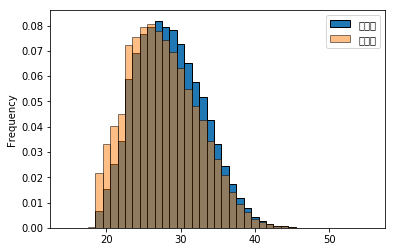

In [14]:
# 選手の満年齢の分布
fig, axes = plt.subplots(1, 1)
df_allplayer_main.plot(kind='hist', y='満年齢', ec='black', bins=bins, ax=axes, normed=True)
df_allplayer_row.plot(kind='hist', y='満年齢', ec='black', bins=bins, ax=axes, normed=True, alpha=0.5)

- 青が主力選手の満年齢の分布で、オレンジが控えも含めた場合の年齢の分布
- 控えも含めると若い年齢の密度が大きい。
- 27才を超える範囲では主力選手のみの場合の密度が高い。

In [15]:
# 控え選手のみのデータを作る
# 投手の控え選手

# 元の投手のDFと、抽出条件のDFを統合
merge_pitcher_mid = merge_pitcher.merge(condition_pitcher, on=['年度', '所属球団'])
# 抽出条件を適用した、マスキング情報
mask = (merge_pitcher_mid.apply(lambda x: x.loc['登板_x']<x.loc['登板_y'], axis=1)) & (merge_pitcher_mid.apply(lambda x: x.loc['投球回_修正_x']<x.loc['投球回_修正_y'], axis=1))
# 投手の抽出情報
merge_pitcher_condition_reserve = merge_pitcher_mid[mask]

# 野手の抽出情報
merge_fielder_condition_reserve = merge_fielder[(merge_fielder['試合']<20) & (merge_fielder['年度']>=1951)]

In [16]:
# 控え選手のみに限定した全選手情報を作成する。
# 投手
merge_pitcher_mid = merge_pitcher_condition_reserve[['年度', '所属球団', '満年齢']]
# 野手
merge_fielder_mid = merge_fielder_condition_reserve[['年度', '所属球団', '満年齢']]
# 主力選手のみの年齢データ作成
df_allplayer_reserve = pd.concat([merge_pitcher_mid, merge_fielder_mid], axis=0)

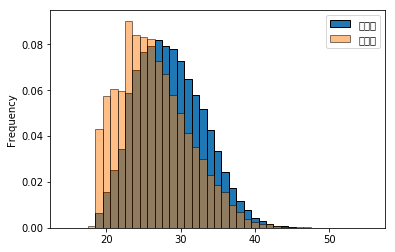

In [17]:
# 選手の満年齢の分布
fig, axes = plt.subplots(1, 1)
df_allplayer_main.plot(kind='hist', y='満年齢', ec='black', bins=bins, ax=axes, normed=True)
df_allplayer_reserve.plot(kind='hist', y='満年齢', ec='black', bins=bins, ax=axes, normed=True, alpha=0.5)

- 控え選手と、主力選手の分布を比較した。
- 控え選手は基本的に若手が中心。
- 30を超えてくると、控え選手としては球団にいられないということなんだということが考えられる。

In [18]:
# AクラスとBクラスのフラグ付けをしていく。
# データの読み込み
win_loss_table = pd.read_sql('select * from win_loss_table', conn)
convert_team_name_table = pd.read_sql('select * from 対応表', conn)

# 勝敗表に略称をつける。
# win_loss_tableの年情報をintに変換する。
win_loss_table = win_loss_table.astype({'年': int}, inplace=True)
# チーム名称の略称を結合する。
win_loss_table = win_loss_table.merge(convert_team_name_table, on=['チーム', '年'])

# いわゆる3位以上をAクラス、4位以下をBクラスとする。
# ただし、チーム数が7の場合は3以上がAクラス、4位以下がBクラスとする。
# 年ごとリーグ毎のチーム数を算出
team_number = win_loss_table.groupby(['リーグ', '年']).size().reset_index()
team_number.rename(columns={0: 'チーム数'}, inplace=True)

# 勝敗表にデータ統合
win_loss_table = win_loss_table.merge(team_number, on=['リーグ', '年'])

# Aクラス、Bクラスをつける
win_loss_table['クラス'] = win_loss_table.apply(lambda x: 'A' if x.loc['順位'] <= x.loc['チーム数']/2. else 'B', axis=1)

In [19]:
# チーム毎の主力選手の平均年齢とクラスをくっつける。
# 年度、球団毎の満年齢を取得
average_age = df_allplayer_main.groupby(['年度', '所属球団'])['満年齢'].mean().reset_index()
# 球団名の修正
average_age['所属球団_修正'] = average_age['所属球団'].apply(lambda x: re.sub(r'\s', '', str(x)))

In [20]:
# 平均年齢のスタッツ。
average_age['満年齢'].describe()

count    828.000000
mean      28.344862
std        1.572262
min       23.500000
25%       27.463599
50%       28.634815
75%       29.476708
max       31.888889
Name: 満年齢, dtype: float64

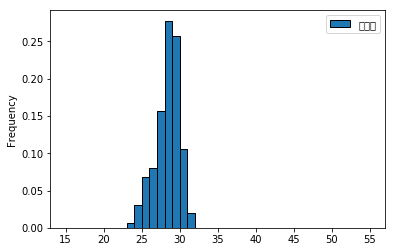

In [21]:
# 平均年齢の分布
average_age.plot(kind='hist', y='満年齢', bins=np.linspace(15,55,41), ec='black', normed=True)

- 27,28にピークが立っている。
- 一番若いのは23.5才, 一番年寄りは31.9才

In [22]:
# バランスの悪いチームとの比較
# 高齢化チーム。上位10%のチーム
percentile_90 = np.percentile(average_age['満年齢'], 90)
# 若すぎるリーム。下位10%のチーム
percentile_10 = np.percentile(average_age['満年齢'], 10)

# バランスの良し悪しをカテゴリ付け
average_age['balance'] = average_age['満年齢'].apply(lambda x: 'good balance' if ((x>percentile_10) & (x<percentile_90)) else 'bad balance')

# 順位表データとマージ
calculate_table = win_loss_table.merge(average_age[['年度', '所属球団_修正', 'balance', '満年齢']], left_on=['年', '略称'], right_on=['年度', '所属球団_修正'])

cross_table = calculate_table.pivot_table(values='URL', index='クラス', columns='balance', aggfunc='count')
# chi2test
print(cross_table)
print('\n')
print(scipy.stats.chi2_contingency(cross_table, correction=False))

balance  bad balance  good balance
クラス                               
A                 86           319
B                 78           333


(0.6467747206691561, 0.421268166729189, 1, array([[ 81.39705882, 323.60294118],
       [ 82.60294118, 328.39705882]]))


- 5%水準で有意差無し。

In [23]:
def get_balance(x, percentile_10, percentile_90):
    if x<=percentile_10:
        return 'too young'
    elif x>=percentile_90:
        return 'too old'
    else:
        return 'good balance'

In [24]:
# バランスの悪いチーム（年寄り、若過ぎ、普通）との比較
# 高齢化チーム。上位10%のチーム
percentile_90 = np.percentile(average_age['満年齢'], 90)
# 若すぎるリーム。下位10%のチーム
percentile_10 = np.percentile(average_age['満年齢'], 10)

# バランスの良し悪しをカテゴリ付け
average_age['balance'] = average_age['満年齢'].apply(lambda x: get_balance(x, percentile_10, percentile_90))

# 順位表データとマージ
calculate_table = win_loss_table.merge(average_age[['年度', '所属球団_修正', 'balance', '満年齢']], left_on=['年', '略称'], right_on=['年度', '所属球団_修正'])

cross_table = calculate_table.pivot_table(values='URL', index='クラス', columns='balance', aggfunc='count')
# chi2test
print(cross_table)
print('\n')
print(scipy.stats.chi2_contingency(cross_table, correction=False))

balance  good balance  too old  too young
クラス                                      
A                 319       46         40
B                 333       34         44


(2.2470935311333586, 0.32512460648410263, 2, array([[323.60294118,  39.70588235,  41.69117647],
       [328.39705882,  40.29411765,  42.30882353]]))


というか、そもそもAクラスとBクラスで平均年齢の平均年齢に差があるかということを調べろよってとこですよね。。。笑

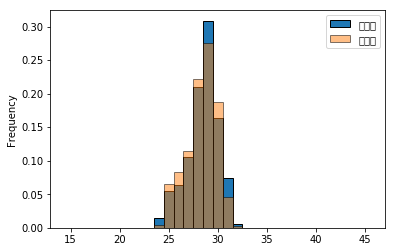

In [25]:
# まずは分布でおおよその傾向を掴みます。
fig, axes = plt.subplots(1, 1)
calculate_table[calculate_table['クラス']=='A'].plot(kind='hist', y='満年齢', ec='black', bins=np.linspace(14.5,45.5,32), ax=axes, normed=True)
calculate_table[calculate_table['クラス']=='B'].plot(kind='hist', y='満年齢', ec='black', bins=np.linspace(14.5,45.5,32), ax=axes, alpha=0.5, normed=True)

- 差があるようには見えない。

In [26]:
A = calculate_table[calculate_table['クラス']=='A']['満年齢']
B = calculate_table[calculate_table['クラス']=='B']['満年齢']
scipy.stats.ttest_ind(A, B, equal_var=True)

Ttest_indResult(statistic=1.2695030226332058, pvalue=0.20462453850472068)

各球団の主力選手の平均年齢について、Aクラスの（平均年齢の）平均とBクラスの（平均年齢の）平均を比較。
- 5%水準で有意差無し。

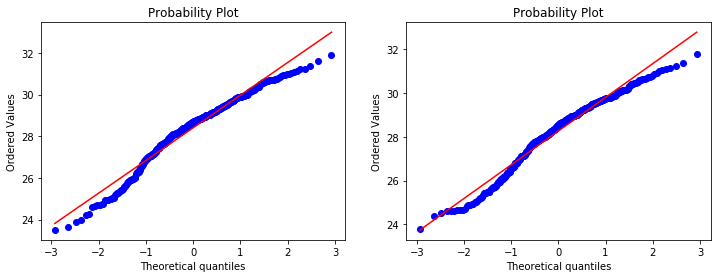

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

x = scipy.stats.probplot(A, plot=ax[0])

x = scipy.stats.probplot(B, plot=ax[1])

- Q-Qプロットで正規生の確認。うーん、微妙
- シャピロウィルク検定で正規性の確認をする。キム仮説は標本分布が正規分布に従うことである。

In [28]:
p_value_A = scipy.stats.shapiro(A)
p_value_B = scipy.stats.shapiro(B)
print('Aクラスの満年齢の平均値に対してシャピロウィルク検定を実施したらp値は{}でした'.format(p_value_A[1]))
print('Bクラスの満年齢の平均値に対してシャピロウィルク検定を実施したらp値は{}でした'.format(p_value_B[1]))

Aクラスの満年齢の平均値に対してシャピロウィルク検定を実施したらp値は2.2187512271898413e-08でした
Bクラスの満年齢の平均値に対してシャピロウィルク検定を実施したらp値は1.1780491604440613e-07でした


- 正規分布に従うことというキム仮説はいずれの場合も棄却されたため、正規分布には従わないということ
- マンホイットニーのU検定を実施する。きむ仮説は2郡間の中央値に差がないこと。

In [29]:
scipy.stats.mannwhitneyu(A, B, use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=87797.5, pvalue=0.1746589762040579)

- 両側対立仮設でもpvalueは5%水準で有意ではなく。AクラスとBクラスの平均年齢の中央値が等しいというキム仮説を棄却できない。

In [30]:
bins=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ['1951-1960', '1961-1970', '1971-1980', '1981-1990', '1991-2000', '2001-2010', '2011-2017']
calculate_table['年代'] = pd.cut(calculate_table['年度'], bins=bins, labels=labels)

In [51]:
calculate_table.pivot_table(values='満年齢', index='年代', columns='クラス', aggfunc='median')

クラス,A,B
年代,,
1951-1960,26.266667,26.142857
1961-1970,27.131429,26.799499
1971-1980,28.913043,28.445286
1981-1990,28.727273,28.864444
1991-2000,28.879227,28.690909
2001-2010,29.598214,29.569712
2011-2017,29.431452,29.285022


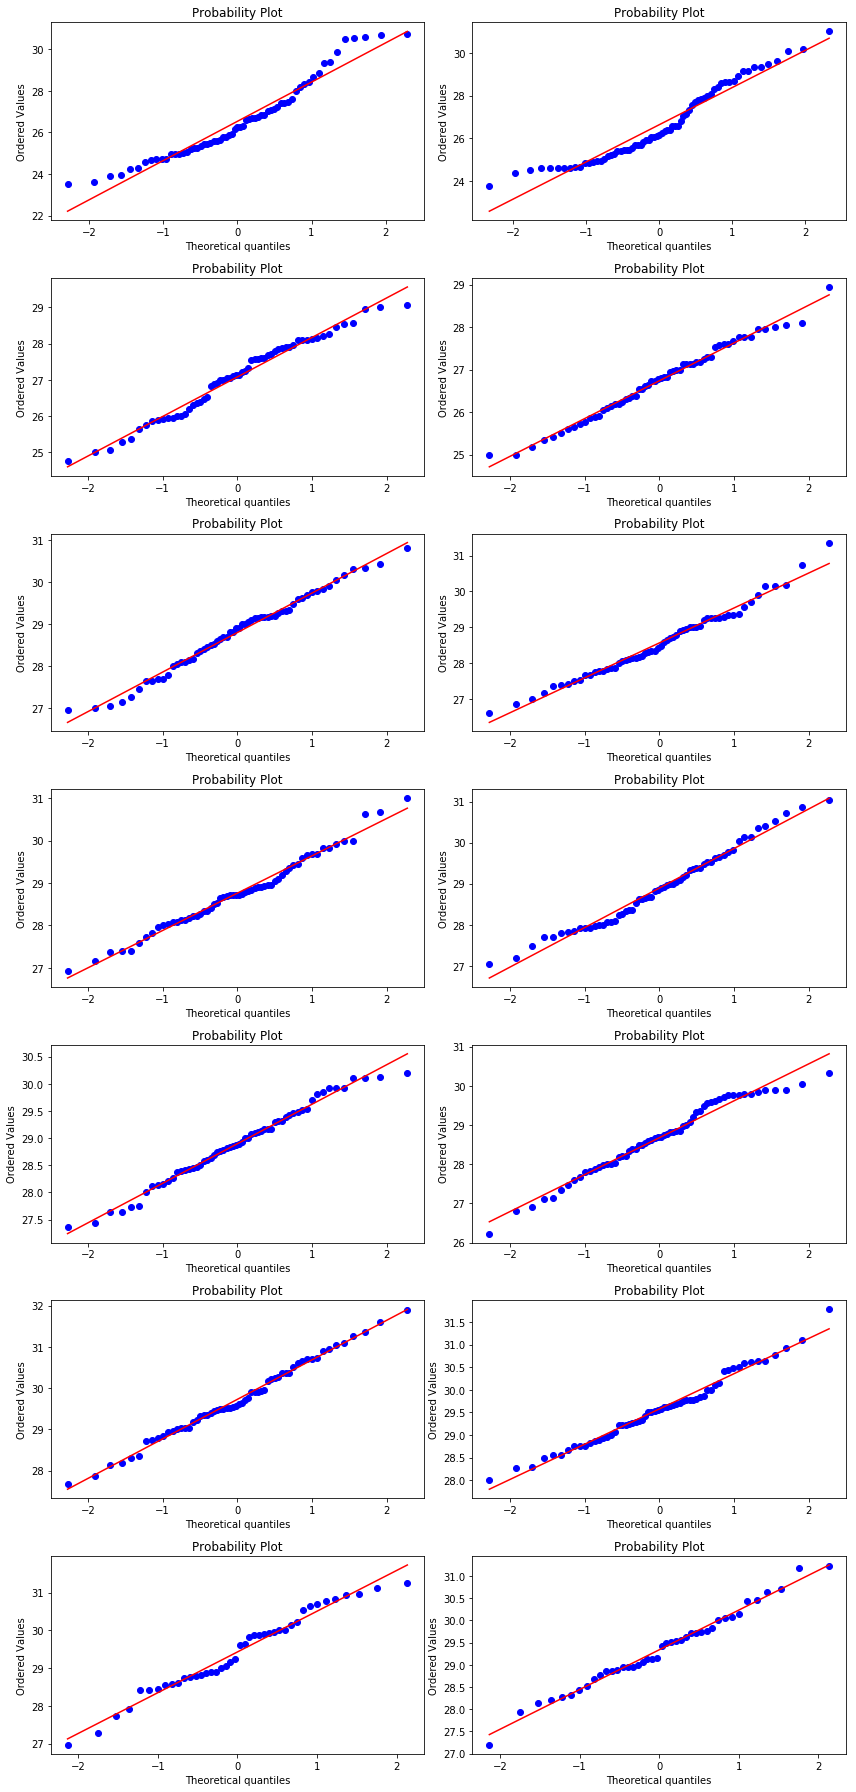

In [43]:
# それぞれでq-qプロットを実行する。
fig, axes = plt.subplots(7,2,figsize=(12,25))
labels = ['1951-1960', '1961-1970', '1971-1980', '1981-1990', '1991-2000', '2001-2010', '2011-2017']
class_ = ['A', 'B']
for i, j in enumerate(product(range(7), range(2))):
    graph_data = calculate_table[(calculate_table['年代']==labels[j[0]]) & (calculate_table['クラス']==class_[j[1]])]
    scipy.stats.probplot(graph_data['満年齢'], plot=axes[j[0]][j[1]])
plt.tight_layout()

- 従っているかどうか微妙なところですな。

In [55]:
# それぞれについてマンホイットニーのU検定を実施します。
for year in labels:
    A = calculate_table[(calculate_table['年代']==year) & (calculate_table['クラス']=='A')]['満年齢']
    B = calculate_table[(calculate_table['年代']==year) & (calculate_table['クラス']=='B')]['満年齢']
    
    s, p = scipy.stats.mannwhitneyu(A, B, use_continuity=True, alternative='two-sided')
    print('{0}の年代でのp値は{1}です。'.format(year, p))

1951-1960の年代でのp値は0.7428894866887257です。
1961-1970の年代でのp値は0.04753883662401981です。
1971-1980の年代でのp値は0.13811737747435643です。
1981-1990の年代でのp値は0.5690215305777934です。
1991-2000の年代でのp値は0.20121685865381111です。
2001-2010の年代でのp値は0.35151598675026086です。
2011-2017の年代でのp値は0.6132302973610764です。


- 両側検定で1961-1970年代では有意差がありという結果がでた。
- しかし7つの年代のうち1つでしかないため、AクラスとBクラスで平均年齢に差があるという仮説は支持されないという判断が妥当である。